# 📊 Análise de Dados de Website: Tráfego e Engajamento

**Baseado no Case:** The iScale  
**Ferramentas:** Python, Pandas, Seaborn

---

## 🎯 Objetivo do Notebook
Este projeto tem como objetivo analisar o comportamento de usuários em um website, identificando padrões de tráfego e qualidade de engajamento por canal de marketing. 

Focaremos em responder perguntas estratégicas como:
* O volume de acessos se traduz em engajamento real?
* Quais canais trazem usuários mais qualificados?
* Qual o melhor horário para publicação de conteúdo?

---

## 1. Configuração do Ambiente
Abaixo, iniciamos importando as bibliotecas essenciais para manipulação de dados (`pandas`, `numpy`) e visualização (`matplotlib`, `seaborn`).

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Coleta e Carregamento de Dados
Nesta etapa, importamos o dataset bruto localizado na pasta `data/raw`. 

Utilizamos o comando `.head()` logo em seguida para realizar uma **inspeção visual inicial**. O objetivo é verificar:
1. Se o arquivo foi lido corretamente.
2. Como o cabeçalho (nomes das colunas) foi interpretado.
3. Se existem linhas de metadados ou "sujeira" antes dos dados reais.

In [34]:
df = pd.read_csv('../data/raw/data-export (1).csv')

df.head()

,# ----------------------------------------,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Session primary channel group (Default channel...,Date + hour (YYYYMMDDHH),Users,Sessions,Engaged sessions,Average engagement time per session,Engaged sessions per user,Events per session,Engagement rate,Event count
1,Direct,2024041623,237,300,144,47.526666666666700,0.6075949367088610,4.673333333333330,0.48,1402
2,Organic Social,2024041719,208,267,132,32.09737827715360,0.6346153846153850,4.295880149812730,0.4943820224719100,1147
3,Direct,2024041723,188,233,115,39.93991416309010,0.6117021276595740,4.587982832618030,0.49356223175965700,1069
4,Organic Social,2024041718,187,256,125,32.16015625,0.6684491978609630,4.078125,0.48828125,1044


## 3. Limpeza e Tratamento de Cabeçalhos
A inspeção inicial revelou que o dataset continha metadados nas primeiras linhas, fazendo com que o Pandas interpretasse o cabeçalho incorretamente.

Para corrigir a estrutura do DataFrame, realizamos as seguintes transformações:
1.  **Correção do Header:** Promovemos a primeira linha de dados (`iloc[0]`) para atuar como o novo cabeçalho das colunas.
2.  **Remoção de Ruído:** Removemos a linha original (índice 0) e resetamos o índice para manter a organização sequencial.
3.  **Renomeação Padronizada:** Substituímos os nomes originais complexos (ex: `Date + hour (YYYYMMDDHH)`) por termos concisos em inglês (ex: `DateHour`, `Users`). Isso não apenas limpa a visualização, mas facilita o acesso às colunas via código (dot notation).

In [35]:
df.columns = df.iloc[0]
df = df.drop(index = 0).reset_index(drop = True)
df.columns = ['Channel Group', 'DateHour', 'Users', 'Sessions', 'Engaged Sessions', 'Average Engagement Time Per Session', 'Engaged Sessions Per User', 'Events Per Session', 'Engagement Rate', 'Event Count']

df.head()

,Channel Group,DateHour,Users,Sessions,Engaged Sessions,Average Engagement Time Per Session,Engaged Sessions Per User,Events Per Session,Engagement Rate,Event Count
0,Direct,2024041623,237,300,144,47.526666666666700,0.6075949367088610,4.673333333333330,0.48,1402
1,Organic Social,2024041719,208,267,132,32.09737827715360,0.6346153846153850,4.295880149812730,0.4943820224719100,1147
2,Direct,2024041723,188,233,115,39.93991416309010,0.6117021276595740,4.587982832618030,0.49356223175965700,1069
3,Organic Social,2024041718,187,256,125,32.16015625,0.6684491978609630,4.078125,0.48828125,1044
4,Organic Social,2024041720,175,221,112,46.918552036199100,0.64,4.529411764705880,0.5067873303167420,1001


## 4. Auditoria de Tipos de Dados (Schema Audit)
Com as colunas renomeadas, utilizamos o método `.info()` para validar a estrutura técnica do dataset.

**Diagnóstico:**
* **Valores Nulos:** Não foram detectados dados faltantes (todos os campos possuem contagem completa).
* **Tipos de Dados:** Observamos um problema crítico: **todas as variáveis** foram interpretadas como `object` (texto).

**Consequência:**
Isso ocorre porque o Pandas leu a sujeira inicial e assumiu que tudo era texto. Se tentássemos somar a coluna `Users` agora, o Python apenas concatenaria as strings.
**Ação Necessária:** A próxima etapa deve focar obrigatoriamente na conversão explícita de tipos (Type Casting) para datas e números.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Channel Group                        3182 non-null   object
 1   DateHour                             3182 non-null   object
 2   Users                                3182 non-null   object
 3   Sessions                             3182 non-null   object
 4   Engaged Sessions                     3182 non-null   object
 5   Average Engagement Time Per Session  3182 non-null   object
 6   Engaged Sessions Per User            3182 non-null   object
 7   Events Per Session                   3182 non-null   object
 8   Engagement Rate                      3182 non-null   object
 9   Event Count                          3182 non-null   object
dtypes: object(10)
memory usage: 248.7+ KB


## 5. Conversão de Tipos e Engenharia de Atributos (Feature Engineering)
Para viabilizar as operações matemáticas e de tempo, executamos três transformações essenciais:

1.  **Parsing de Datas:** Convertemos a coluna `DateHour` para o formato `datetime`, especificando o padrão `%Y%m%d%H` (AnoMêsDiaHora) para garantir a leitura correta.
2.  **Casting Numérico:** Aplicamos a função `to_numeric` em lote para todas as colunas de métricas, garantindo que "Sessões" e "Usuários" sejam tratados como números, não texto.
3.  **Criação de Features:** Derivamos uma nova coluna chamada `Hour` extraindo apenas a hora do dia (0-23). Essa variável será fundamental para a análise de sazonalidade horária (Heatmap) nas etapas seguintes.

**Validação:** Ao final, executamos o `.info()` novamente para confirmar que os tipos agora estão corretos (`datetime64`, `float64`/`int64`) e prontos para análise.

In [38]:
df['DateHour'] = pd.to_datetime(df['DateHour'], format='%Y%m%d%H', errors='coerce')

numeric_cols = df.columns.drop(['Channel Group', 'DateHour'])
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors = 'coerce')
df['Hour'] = df['DateHour'].dt.hour

df.to_csv('../data/processed/dados_tratados_final.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Channel Group                        3182 non-null   object        
 1   DateHour                             3182 non-null   datetime64[ns]
 2   Users                                3182 non-null   int64         
 3   Sessions                             3182 non-null   int64         
 4   Engaged Sessions                     3182 non-null   int64         
 5   Average Engagement Time Per Session  3182 non-null   float64       
 6   Engaged Sessions Per User            3182 non-null   float64       
 7   Events Per Session                   3182 non-null   float64       
 8   Engagement Rate                      3182 non-null   float64       
 9   Event Count                          3182 non-null   int64         
 10  Hour        

## 6. Análise Estatística Descritiva (Descriptive Statistics)
Agora que os dados estão limpos, utilizamos o método `.describe()` para obter um panorama estatístico das variáveis numéricas. Isso nos ajuda a detectar anomalias e entender a distribuição dos dados antes da visualização.

**O que observar nos resultados abaixo:**
1.  **Janela de Tempo:** Verificando o `min` e `max` da coluna `DateHour`, confirmamos que o dataset cobre o período de **06 de Abril a 03 de Maio de 2024**.
2.  **Indícios de Outliers:** Note a coluna `Average Engagement Time`. A média (`mean`) é de ~66 segundos, mas o valor máximo (`max`) é de **4525 segundos**. Isso indica a presença de sessões extremas (outliers) que podem distorcer a média.
3.  **Volume Médio:** Em média, o site recebe cerca de **42 usuários por hora** (ver linha `mean` da coluna `Users`).

In [9]:
df.describe()

,DateHour,Users,Sessions,Engaged Sessions,Average Engagement Time Per Session,Engaged Sessions Per User,Events Per Session,Engagement Rate,Event Count,Hour
count,3182,3182.000000,3182.000000,3182.000000,3182.000000,3182.000000,3182.000000,3182.000000,3182.000000,3182.000000
mean,2024-04-20 01:17:07.278441216,41.935889,51.192646,28.325581,66.644581,0.606450,4.675969,0.503396,242.272470,11.807040
min,2024-04-06 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2024-04-13 02:15:00,20.000000,24.000000,13.000000,32.103034,0.561404,3.750000,0.442902,103.000000,6.000000
50%,2024-04-20 02:00:00,42.000000,51.000000,27.000000,49.020202,0.666667,4.410256,0.545455,226.000000,12.000000
75%,2024-04-26 22:00:00,60.000000,71.000000,41.000000,71.487069,0.750000,5.217690,0.633333,339.000000,18.000000
max,2024-05-03 23:00:00,237.000000,300.000000,144.000000,4525.000000,2.000000,56.000000,1.000000,1402.000000,23.000000
std,NaN,29.582258,36.919962,20.650569,127.200659,0.264023,2.795228,0.228206,184.440313,6.886686


## 7. Análise de Tendências Temporais (Time Series Analysis)
A primeira etapa da análise exploratória foca na evolução do tráfego ao longo do tempo. Agrupamos os dados pela coluna `DateHour` para visualizar a volumetria horária.

### ❓ Pergunta de Negócio 1:
**Quais padrões ou tendências observamos em sessões e usuários ao longo do tempo?**

O gráfico abaixo compara duas métricas fundamentais:
* **Users (Laranja):** Pessoas únicas que visitaram o site.
* **Sessions (Azul):** Total de visitas (uma mesma pessoa pode visitar várias vezes).


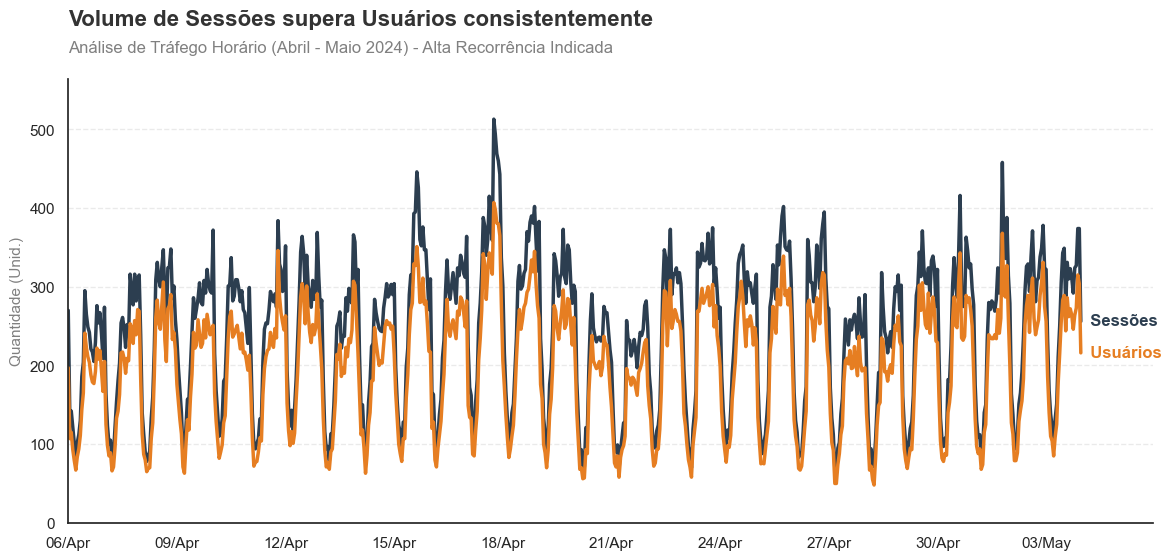

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

data_plot = df.groupby('DateHour')[['Sessions', 'Users']].sum()


sns.set_style("white") 
fig, ax = plt.subplots(figsize=(14, 6)) 

ax.plot(data_plot.index, data_plot['Sessions'], color='#2c3e50', linewidth=2.5, label='Sessões')
ax.plot(data_plot.index, data_plot['Users'], color='#e67e22', linewidth=2.5, label='Usuários')

last_date = data_plot.index[-1]
last_session_val = data_plot['Sessions'].iloc[-1]
last_user_val = data_plot['Users'].iloc[-1]

ax.set_xlim(data_plot.index[0], last_date + pd.Timedelta(days=2))

ax.text(last_date, last_session_val, '  Sessões', color='#2c3e50', fontweight='bold', va='center')
ax.text(last_date, last_user_val, '  Usuários', color='#e67e22', fontweight='bold', va='center')

ax.set_ylim(0, data_plot['Sessions'].max() * 1.1)
ax.set_ylabel('Quantidade (Unid.)', fontsize=11, color='gray')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))

sns.despine()
ax.grid(axis='y', linestyle='--', alpha=0.4)

ax.text(x=0, y=1.12, s="Volume de Sessões supera Usuários consistentemente", 
        transform=ax.transAxes, 
        fontsize=16, fontweight='bold', color='#333333', ha='left')


ax.text(x=0, y=1.06, s="Análise de Tráfego Horário (Abril - Maio 2024) - Alta Recorrência Indicada", 
        transform=ax.transAxes, 
        fontsize=12, color='gray', ha='left')

plt.subplots_adjust(top=0.85)
plt.savefig('../images/evolucao_sessoes_vs_usuarios.png', dpi=300, bbox_inches='tight')
plt.show()

### 📊 Insights da Análise Temporal

**1. Retenção de Usuários (Stickiness):**
Observamos que a curva de **Sessões** (Azul) mantém-se consistentemente acima da curva de **Usuários** (Laranja).
* **Interpretação:** Isso indica uma taxa de recorrência saudável. O mesmo usuário está retornando ao site múltiplas vezes dentro do mesmo período, o que sugere fidelidade e interesse no conteúdo.

**2. Sazonalidade Diária (Padrão "Batimento Cardíaco"):**
Ao contrário de um movimento aleatório, o gráfico apresenta ciclos diários bem definidos (picos durante o dia e vales profundos durante a madrugada).
* **Ação:** Isso valida a necessidade de investigar o *horário nobre* do site (realizado na Pergunta 6) para otimizar o timing das campanhas.

**3. Detecção de Anomalias (Outliers):**
Identificamos um pico anormal de tráfego entre os dias **17 e 18 de Abril**, onde o volume de sessões superou significativamente a média.
* **Hipótese:** Provável resultado de uma campanha de marketing específica, viralização de conteúdo ou disparo de e-mail marketing. Este evento merece uma investigação isolada para replicar o sucesso.

## 8. Análise de Aquisição por Canal (Channel Attribution)
Após entendermos o comportamento temporal, mudamos o foco para a **Atribuição de Tráfego**. O objetivo aqui é identificar quais fontes de tráfego (Canais) são os verdadeiros motores de crescimento do site.

### ❓ Pergunta de Negócio 2:
**Qual canal de marketing trouxe o maior número de usuários e como podemos utilizar esse insight para otimizar outras fontes?**

Para responder, realizamos um agrupamento categórico:
1.  Somamos o total de **Usuários Únicos** por `Channel Group`.
2.  Ordenamos o resultado de forma decrescente para criar um ranking de performance.
3.  Visualizamos a distribuição para comparar a dependência do negócio em relação a canais específicos (ex: Risco de dependência de algoritmo de redes sociais vs. tráfego orgânico estável).

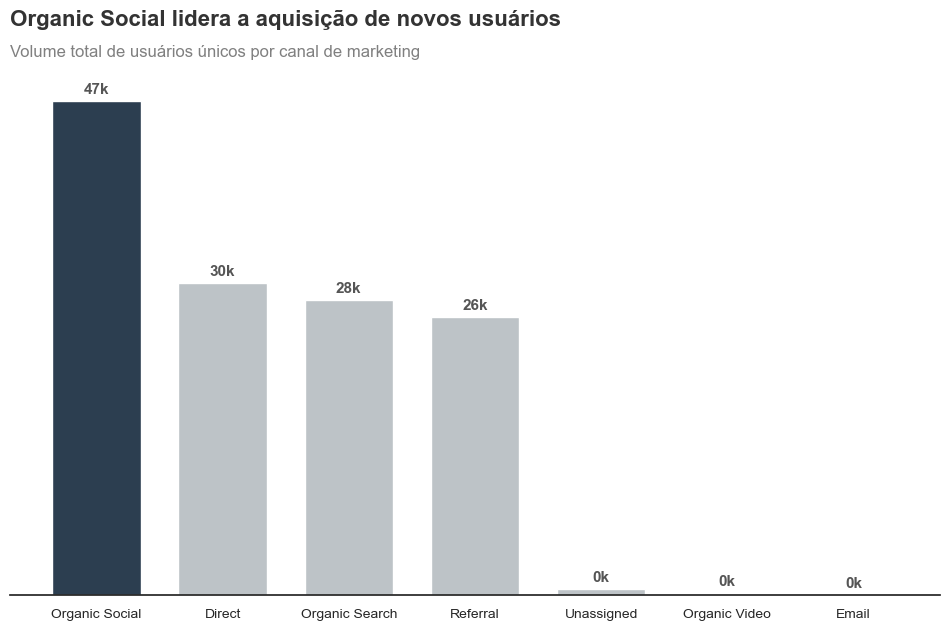

In [41]:
channel_users = df.groupby('Channel Group')['Users'].sum().sort_values(ascending=False)

sns.set_style("white")
fig, ax = plt.subplots(figsize=(12, 7))

colors = ['#2c3e50' if (x == channel_users.max()) else '#bdc3c7' for x in channel_users]

bars = ax.bar(channel_users.index, channel_users.values, color=colors, width=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 500, 
            f'{int(height/1000)}k', 
            ha='center', va='bottom', fontsize=11, fontweight='bold', color='#555555')

ax.set_yticks([]) 
ax.set_ylabel('')
ax.set_xlabel('')

plt.xticks(rotation=0, fontsize=10) 

sns.despine(left=True) 

ax.text(x=0, y=1.1, s="Organic Social lidera a aquisição de novos usuários", 
        transform=ax.transAxes, 
        fontsize=16, fontweight='bold', color='#333333', ha='left')

ax.text(x=0, y=1.04, s="Volume total de usuários únicos por canal de marketing", 
        transform=ax.transAxes, 
        fontsize=12, color='gray', ha='left')

plt.subplots_adjust(top=0.85) 
plt.savefig('../images/total_usuarios_por_canal.png', dpi=300, bbox_inches='tight')
plt.show()

### 📊 Insights de Aquisição de Usuários

**1. Hegemonia do Tráfego Social:**
O canal **Organic Social** é, isoladamente, a maior fonte de atração, trazendo quase o dobro de usuários do segundo colocado.
* **Ponto Positivo:** A marca possui forte presença e viralidade nas redes.
* **Ponto de Atenção:** Alta dependência de plataformas de terceiros (risco de algoritmo).

**2. A Força da Marca (Direct):**
O tráfego **Direct** (segundo lugar) indica que muitos usuários já conhecem a URL de cor ou possuem o site nos favoritos, demonstrando um *Brand Awareness* consolidado.

**3. O Papel do Referral:**
O tráfego de **Referral** (links em sites parceiros, blogs ou notícias) aparece como quarta força. Embora menor que o Social, geralmente traz usuários mais qualificados, pois já vêm com um contexto de recomendação.

**4. Oportunidades Inexploradas:**
Canais como **Email** e **Organic Video** têm volume inexpressivo nesta etapa. Isso sugere que não há estratégias ativas de CRM (Newsletters) ou YouTube no momento, representando grandes avenidas de crescimento futuro.


## 9. Análise de Qualidade: Tempo de Engajamento
Enquanto a análise anterior focou em *quem traz mais gente* (Volume), esta etapa foca em *quem fica mais tempo* (Retenção). 

O **Tempo Médio de Engajamento** é um indicador crítico de "Product-Market Fit". Se o usuário fica muito tempo, o conteúdo é relevante para ele.

### ❓ Pergunta de Negócio 3:
**Qual canal tem o maior tempo médio de engajamento e o que isso nos diz sobre o comportamento do usuário?**

Para responder, calculamos a média da coluna `Average Engagement Time Per Session` agendada por canal. Isso nos permite contrastar canais de "clique rápido" (que entram e saem) com canais de "consumo profundo".

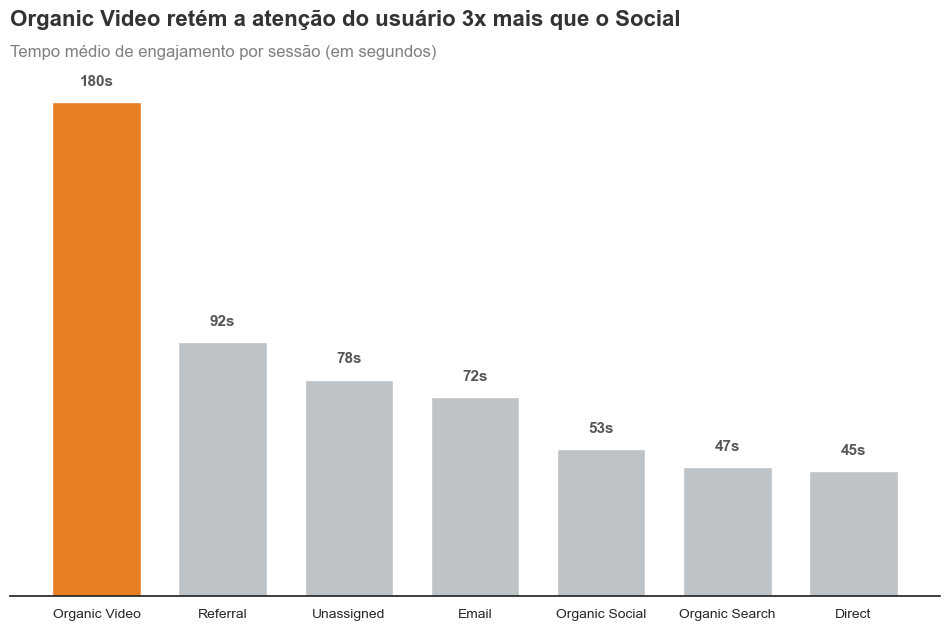

In [42]:
avg_time = df.groupby('Channel Group')['Average Engagement Time Per Session'].mean().sort_values(ascending=False)

sns.set_style("white")
fig, ax = plt.subplots(figsize=(12, 7))

colors = ['#e67e22' if (x == avg_time.max()) else '#bdc3c7' for x in avg_time]

bars = ax.bar(avg_time.index, avg_time.values, color=colors, width=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5, 
            f'{int(height)}s',
            ha='center', va='bottom', fontsize=11, fontweight='bold', color='#555555')

ax.set_yticks([]) 
ax.set_ylabel('')
ax.set_xlabel('')
sns.despine(left=True) 

plt.xticks(rotation=0, fontsize=10) 

ax.text(x=0, y=1.1, s="Organic Video retém a atenção do usuário 3x mais que o Social", 
        transform=ax.transAxes, 
        fontsize=16, fontweight='bold', color='#333333', ha='left')

ax.text(x=0, y=1.04, s="Tempo médio de engajamento por sessão (em segundos)", 
        transform=ax.transAxes, 
        fontsize=12, color='gray', ha='left')

plt.subplots_adjust(top=0.85)
plt.savefig('../images/tempo_engajamento_por_canal.png', dpi=300, bbox_inches='tight')
plt.show()

### 📊 Insights de Engajamento e Retenção de Atenção

**1. O Paradoxo Volume x Qualidade:**
Ao cruzar os dados com a análise anterior, notamos uma inversão completa. O **Organic Video**, que tinha um dos menores volumes de tráfego, apresenta o **Maior Tempo Médio de Engajamento** (~180 segundos).
* **Conclusão:** O público de vídeo é um nicho altamente qualificado. Quem clica, consome o conteúdo até o fim.

**2. O Comportamento "Fast Food" das Redes Sociais:**
O **Organic Social** (líder em volume) tem um tempo de permanência baixo (~50 segundos).
* **Interpretação:** O usuário de redes sociais está em modo de "rolagem rápida". Ele entra, escaneia e sai. Não é o melhor canal para conteúdos densos ou vendas complexas.

**3. Recomendação Estratégica:**
Existe uma oportunidade clara de **aumentar o investimento em Vídeo**. Se conseguirmos ampliar o alcance (topo do funil) deste canal mantendo essa taxa de retenção, o impacto na conversão final será exponencialmente maior do que insistir apenas em volume nas redes sociais.

## 10. Distribuição da Taxa de Engajamento (Engagement Rate Distribution)
Muitas vezes, a média pode ser enganosa. Um canal pode ter um tempo médio alto apenas porque alguns poucos usuários ficaram horas no site, mascarando a maioria que saiu imediatamente.

### ❓ Pergunta de Negócio 4:
**Como a Taxa de Engajamento varia entre os diferentes canais? Existe consistência na qualidade do tráfego?**

Para responder a isso, utilizamos um **Boxplot (Diagrama de Caixa)**. Este gráfico nos permite visualizar a dispersão dos dados:
* **Caixas curtas:** Indicam que os usuários têm comportamento homogêneo (previsível).
* **Caixas longas:** Indicam alta variabilidade (comportamento instável).
* **Mediana (Linha central):** O ponto onde 50% dos usuários estão acima e 50% abaixo.

> **Nota de Visualização:** Para facilitar a leitura do comportamento padrão da maioria dos usuários, os *outliers* (valores extremos) foram ocultados visualmente neste gráfico.

C:\Users\Luiz Otávio\AppData\Local\Temp\ipykernel_7380\2569966895.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Channel Group', y='Engagement Rate',


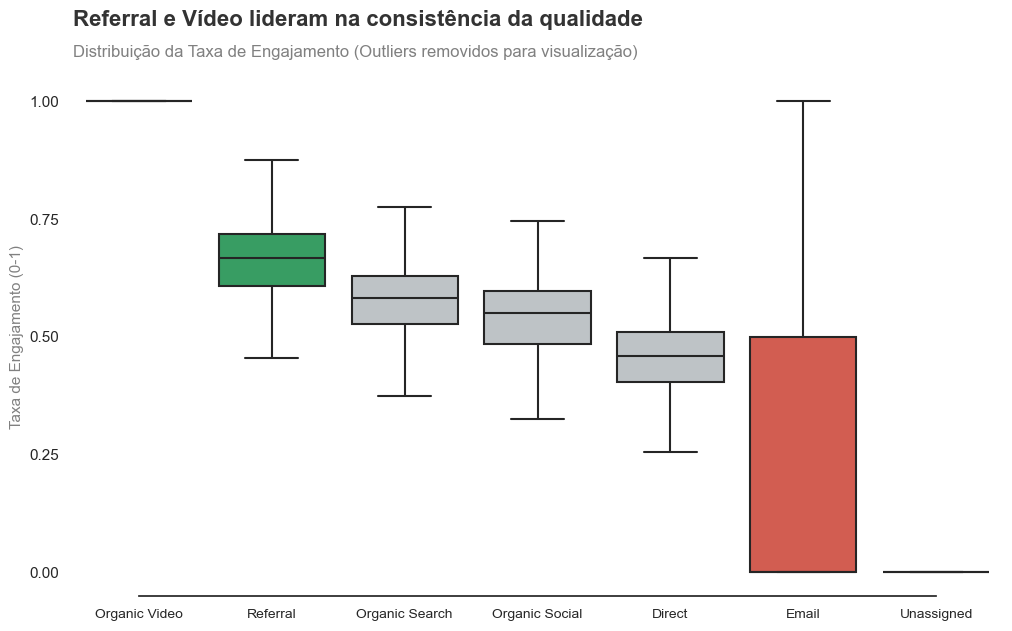

In [44]:
sorted_idx = df.groupby('Channel Group')['Engagement Rate'].median().sort_values(ascending=False).index

sns.set_style("white")
fig, ax = plt.subplots(figsize=(12, 7))

my_palette = {
    'Organic Video': '#2c3e50',  
    'Referral': '#27ae60',      
    'Email': '#e74c3c',          
    'Organic Social': '#bdc3c7', 
    'Organic Search': '#bdc3c7',
    'Direct': '#bdc3c7',
    'Unassigned': '#bdc3c7'
}

sns.boxplot(data=df, x='Channel Group', y='Engagement Rate', 
            order=sorted_idx, 
            palette=my_palette, 
            linewidth=1.5, 
            showfliers=False,  
            ax=ax)

sns.despine(trim=True, left=True)
ax.set_ylabel('Taxa de Engajamento (0-1)', fontsize=11, color='gray')
ax.set_xlabel('')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0]) 

plt.xticks(rotation=0, fontsize=10)

ax.text(x=0, y=1.1, s="Referral e Vídeo lideram na consistência da qualidade", 
        transform=ax.transAxes, 
        fontsize=16, fontweight='bold', color='#333333', ha='left')

ax.text(x=0, y=1.04, s="Distribuição da Taxa de Engajamento (Outliers removidos para visualização)", 
        transform=ax.transAxes, 
        fontsize=12, color='gray', ha='left')

plt.subplots_adjust(top=0.85)
plt.savefig('../images/distribuicao_engajamento_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

### 📊 Insights de Distribuição de Engajamento

**1. A Instabilidade do E-mail Marketing:**
O canal **Email** apresenta a maior dispersão de dados (a caixa mais longa), variando drasticamente de 0.0 a 1.0.
* **Interpretação:** Isso sugere falta de segmentação. Algumas campanhas funcionam muito bem (topo da caixa), enquanto outras são rejeitadas imediatamente (fundo da caixa). O canal precisa de otimização urgente.

**2. Referral: A Melhor Qualidade Média:**
O canal **Referral** apresenta a mediana mais alta (linha central ~0.65) entre os canais de volume.
* **Conclusão:** Usuários que chegam por links de terceiros ou parceiros tendem a ser mais qualificados do que aqueles que vêm de redes sociais ou busca orgânica.

**3. Consistência em Social e Search:**
Os canais de maior volume (**Social e Search**) mostram caixas compactas e medianas próximas a 0.55. Isso indica um comportamento de usuário previsível e estável, fundamental para projeções de tráfego.

## 11. Análise de Eficiência: Sessões Engajadas vs. Não Engajadas
Volume de tráfego não é sinônimo de sucesso. Para entender a real eficiência de cada canal, precisamos decompor o tráfego total em duas categorias:
1.  **Sessões Engajadas:** Visitas de valor (conversão potencial).
2.  **Sessões Não Engajadas:** Visitas de rejeição (custo sem retorno).

### ❓ Pergunta de Negócio 5:
**Quais canais estão gerando mais sessões engajadas em comparação com as não engajadas? Onde estamos desperdiçando recursos atraindo tráfego desqualificado?**

**Metodologia Técnica:**
Para esta visualização, realizamos uma transformação nos dados (unpivot/melt). Calculamos o volume de sessões "Não Engajadas" (`Total - Engajadas`) e colocamos as métricas lado a lado para cada canal. Isso revela visualmente a "taxa de desperdício" de tráfego.

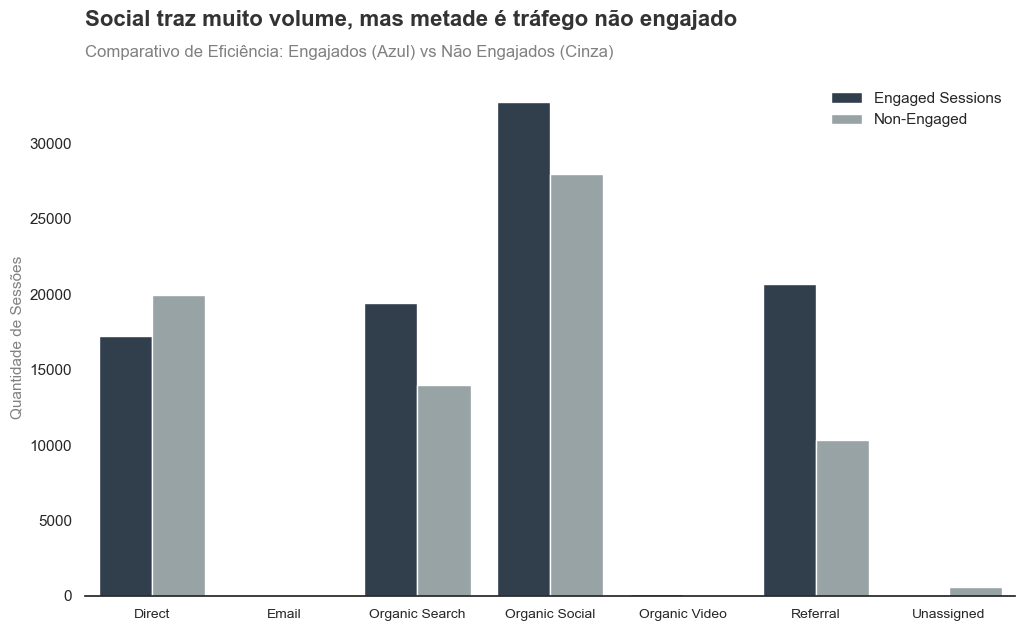

In [46]:
session_df = df.groupby('Channel Group')[['Sessions', 'Engaged Sessions']].sum().reset_index()
session_df['Non-Engaged'] = session_df['Sessions'] - session_df['Engaged Sessions']
session_df_melted = session_df.melt(id_vars='Channel Group', value_vars=['Engaged Sessions', 'Non-Engaged'])

sns.set_style("white")
fig, ax = plt.subplots(figsize=(12, 7))

my_palette = {"Engaged Sessions": "#2c3e50", "Non-Engaged": "#95a5a6"}

sns.barplot(data=session_df_melted, 
            x="Channel Group", 
            y="value", 
            hue="variable", 
            palette=my_palette,
            ax=ax)

sns.despine(left=True)
ax.set_ylabel('Quantidade de Sessões', fontsize=11, color='gray')
ax.set_xlabel('')
ax.legend(title='', frameon=False, loc='upper right') 

plt.xticks(rotation=0, fontsize=10)


ax.text(x=0, y=1.1, s="Social traz muito volume, mas metade é tráfego não engajado", 
        transform=ax.transAxes, 
        fontsize=16, fontweight='bold', color='#333333', ha='left')

ax.text(x=0, y=1.04, s="Comparativo de Eficiência: Engajados (Azul) vs Não Engajados (Cinza)", 
        transform=ax.transAxes, 
        fontsize=12, color='gray', ha='left')

plt.subplots_adjust(top=0.85)
plt.savefig('../images/comparativo_engajados_vs_nao_engajados.png', dpi=300, bbox_inches='tight')
plt.show()

### 📊 Insights de Eficiência de Tráfego

**1. O Problema do Tráfego "Direct":**
O canal **Direct** é o único onde o volume de sessões **Não Engajadas** supera as Engajadas.
* **Diagnóstico:** Isso geralmente indica tráfego de baixa qualidade, bots ou usuários que acessam a home e saem imediatamente. É um canal de "desperdício" neste momento.

**2. O Desperdício Geral (Taxa de Rejeição):**
Apesar de canais como **Organic Social** e **Search** terem saldo positivo (mais engajados que não-engajados), a barra de "Não Engajados" permanece muito alta em termos absolutos.
* **Ação Recomendada:** O problema pode não estar no marketing, mas na **Experiência do Usuário (UX)**. O site pode estar lento, não responsivo ou com conteúdo que não entrega o que prometeu no anúncio.

**3. A Eficiência do Referral:**
Mais uma vez, o **Referral** se destaca. A proporção de sessões engajadas é visivelmente superior às não engajadas, confirmando ser o tráfego mais "limpo" e rentável.

## 12. Sazonalidade Horária: Mapa de Calor de Tráfego (Traffic Heatmap)
Saber *quem* são seus usuários é importante, mas saber *quando* eles estão ativos é crucial para a operação. 

O comportamento do usuário muda drasticamente ao longo do dia. Um canal pode ser noturno (ex: Redes Sociais) enquanto outro é comercial (ex: E-mail Corporativo).

### ❓ Pergunta de Negócio 6:
**Em quais horários do dia cada canal gera mais tráfego? Como podemos otimizar o agendamento de postagens e campanhas?**

**Metodologia Técnica:**
Para visualizar essa interseção, construímos uma **Matriz de Intensidade (Heatmap)**:
1.  **Agrupamento Cruzado:** Agrupamos os dados por `Hour` (0-23h) e `Channel Group`.
2.  **Pivotagem (Unstack):** Transformamos as linhas em colunas para criar uma grade onde o eixo X são os Canais e o eixo Y são as Horas.
3.  **Escala de Cor:** Utilizamos cores quentes (escuras) para indicar picos de tráfego e cores frias (claras) para horários de ociosidade.

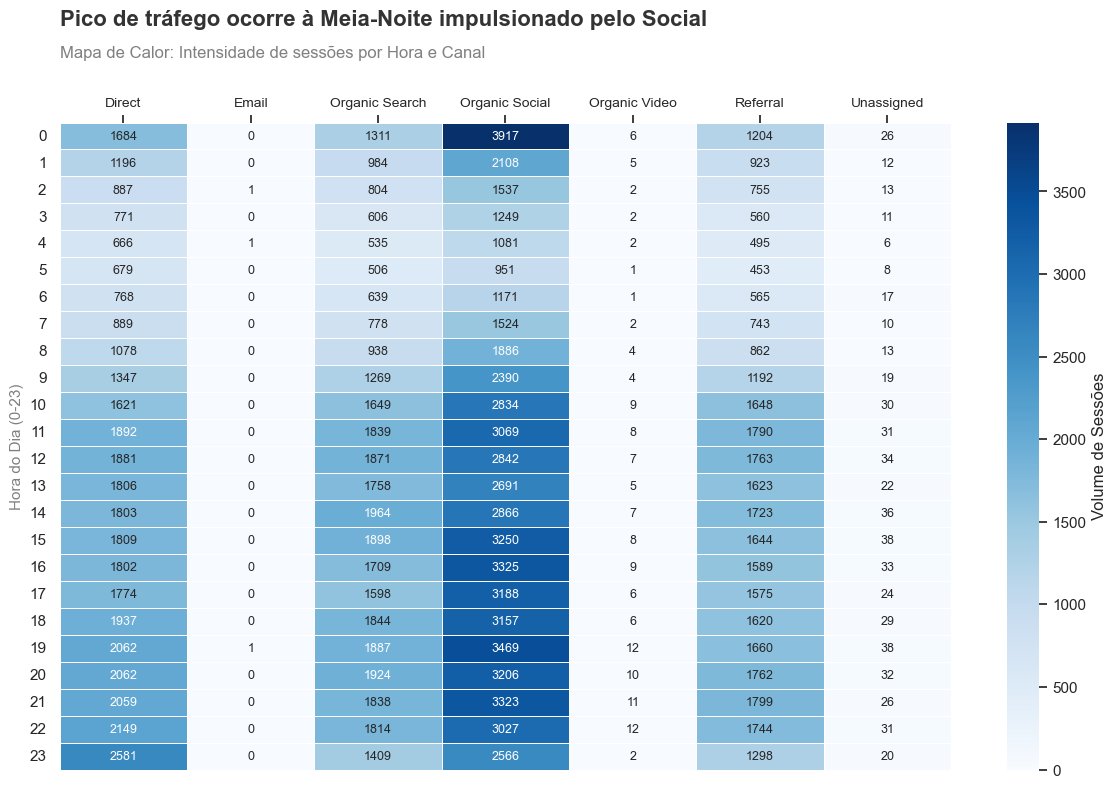

In [49]:
heatmap_data = df.groupby(['Hour', 'Channel Group'])['Sessions'].sum().unstack().fillna(0)

sns.set_style("white")
plt.figure(figsize=(12, 8)) 

sns.heatmap(heatmap_data, 
            cmap='Blues', 
            linewidths=0.5, 
            linecolor='white',
            annot=True, 
            fmt='.0f', 
            annot_kws={"size": 9}, 
            cbar_kws={'label': 'Volume de Sessões'}) 

plt.ylabel('Hora do Dia (0-23)', fontsize=11, color='gray')
plt.xlabel('')
plt.yticks(rotation=0) 

plt.gca().xaxis.tick_top()
plt.xticks(rotation=0, fontsize=10) 

plt.text(x=0, y=1.15, s="Pico de tráfego ocorre à Meia-Noite impulsionado pelo Social", 
         transform=plt.gca().transAxes, 
         fontsize=16, fontweight='bold', color='#333333', ha='left')

plt.text(x=0, y=1.10, s="Mapa de Calor: Intensidade de sessões por Hora e Canal", 
         transform=plt.gca().transAxes, 
         fontsize=12, color='gray', ha='left')

plt.tight_layout() 
plt.savefig('../images/heatmap_trafego_hora_canal.png', dpi=300, bbox_inches='tight')
plt.show()

### 📊 Insights de Sazonalidade Horária (Heatmap)

**1. O Padrão "Night Owl" (Corujas da Noite) no Social:**
O canal **Organic Social** apresenta um comportamento noturno agressivo.
* **Pico Absoluto:** O maior volume de tráfego ocorre à **00:00 (Meia-noite)** com ~3.900 sessões, seguido por uma alta concentração entre **19h e 21h**.
* **Ação Estratégica:** Programar postagens e anúncios para o início da noite (18h-19h) para capturar essa onda de tráfego crescente, ou testar conteúdos de "madrugada".

**2. O Padrão "Horário Comercial" no Search e Direct:**
Diferente do Social, os canais **Organic Search** e **Direct** têm tráfego mais distribuído durante o dia, com foco entre **10:00 e 16:00**.
* **Interpretação:** Sugere um uso mais utilitário ou profissional, onde o usuário busca informações durante o horário de trabalho/estudo.

**3. Ociosidade da Madrugada:**
Entre **02:00 e 06:00** da manhã, o site "dorme". O tráfego cai drasticamente em todos os canais (áreas verde-claras/amarelas), o que é o momento ideal para janelas de manutenção técnica.

## 13. Correlação: Volume de Tráfego vs. Taxa de Engajamento
Existe uma crença comum no marketing digital de que "quando se aumenta o volume, perde-se qualidade". Esta etapa visa validar estatisticamente essa hipótese em nosso dataset.

### ❓ Pergunta de Negócio 7:
**Existe alguma correlação entre alto tráfego (sessões) e alta taxa de engajamento ao longo do tempo? O aumento de público dilui a qualidade da visita?**

**Metodologia Técnica:**
Utilizamos um **Gráfico de Dispersão (Scatter Plot)** onde cada ponto representa uma hora específica do nosso histórico.
* **Eixo X:** Volume de Sessões (Quantidade).
* **Eixo Y:** Taxa de Engajamento (Qualidade).
* **Linha de Tendência (Regressão):** Uma linha descendente indicaria correlação negativa (mais tráfego = pior qualidade). Uma linha reta ou ascendente indicaria escalabilidade saudável.

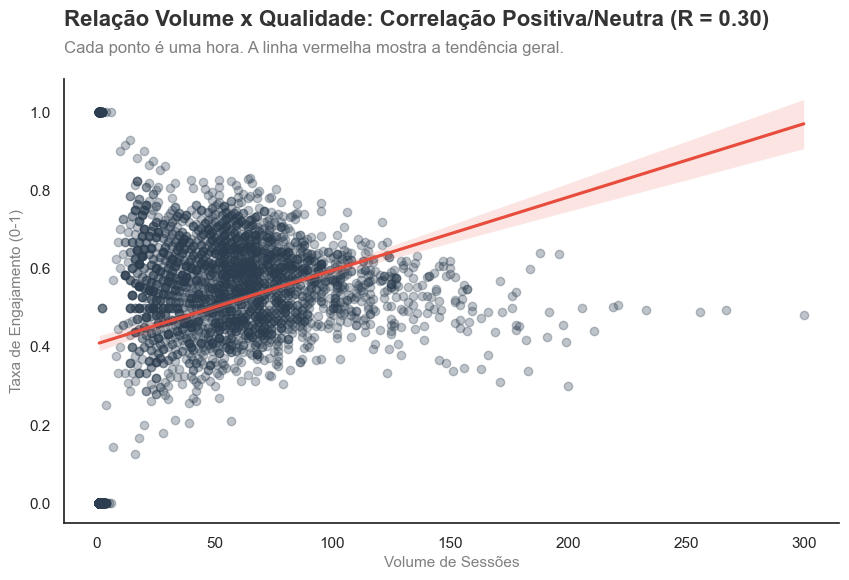

In [51]:

from scipy.stats import pearsonr

corr, _ = pearsonr(df['Sessions'], df['Engagement Rate'])

sns.set_style("white")
fig, ax = plt.subplots(figsize=(10, 6))

sns.regplot(data=df, x='Sessions', y='Engagement Rate', 
            scatter_kws={'alpha': 0.3, 'color': '#2c3e50'}, 
            line_kws={'color': '#e74c3c'},
            ax=ax)

sns.despine()
ax.set_ylabel('Taxa de Engajamento (0-1)', fontsize=11, color='gray')
ax.set_xlabel('Volume de Sessões', fontsize=11, color='gray')

insight_text = "Correlação Negativa" if corr < 0 else "Correlação Positiva/Neutra"

ax.text(x=0, y=1.12, s=f"Relação Volume x Qualidade: {insight_text} (R = {corr:.2f})", 
        transform=ax.transAxes, 
        fontsize=16, fontweight='bold', color='#333333', ha='left')

ax.text(x=0, y=1.06, s="Cada ponto é uma hora. A linha vermelha mostra a tendência geral.", 
        transform=ax.transAxes, 
        fontsize=12, color='gray', ha='left')

plt.subplots_adjust(top=0.85)
plt.savefig('../images/correlacao_volume_vs_qualidade.png', dpi=300, bbox_inches='tight')
plt.show()

### 📊 Insights de Correlação (Escalabilidade)

**1. Correlação Positiva Surpreendente (R = 0.31):**
Contrariando a hipótese de "diluição de qualidade", os dados mostram uma correlação positiva moderada.
* **Conclusão:** Horários com maior volume de tráfego tendem a ter também taxas de engajamento superiores.

**2. Validação de Product-Market Fit:**
O fato da linha de tendência ser ascendente indica que o site possui alta escalabilidade. O conteúdo atrai um público qualificado mesmo em momentos de pico, sugerindo que campanhas de tráfego pago ou viralização não prejudicam a experiência do usuário ou a relevância da audiência.

**3. Segurança para Investimento:**
Este indicador fornece segurança estatística para aumentar o investimento em aquisição (topo de funil), pois historicamente o aumento de volume não trouxe "tráfego lixo", mas sim usuários engajados.

# 14. Conclusão Executiva e Recomendações Estratégicas

Após a análise exploratória dos dados de tráfego (Abril-Maio 2024), consolidamos os seguintes direcionamentos para a diretoria de marketing:

### 🚀 1. Otimização de Investimento (Onde colocar o dinheiro)
* **Aumentar Aporte em Vídeo:** O canal **Organic Video** provou ser o campeão de retenção (3x mais tempo que Social). Recomendamos testar campanhas pagas neste formato para tentar escalar esse público de alta qualidade.
* **Investir em Referral:** Identificamos como o "porto seguro" da operação. Parcerias com outros sites trazem usuários qualificados e fiéis. É a melhor aposta para diversificar o risco da dependência das redes sociais.

### ⚙️ 2. Melhoria Operacional (Onde corrigir erros)
* **Limpeza de Tráfego Direct:** O alto volume de rejeição no canal **Direct** sugere tráfego sujo (bots/interno). Recomendamos auditoria técnica e filtragem de IPs para não distorcer as métricas de conversão.
* **Revisão de E-mail Marketing:** A alta volatilidade (Boxplot) indica que nossos e-mails oscilam entre "sucesso total" e "fracasso total". É necessário segmentar melhor a base antes do disparo.

### 📅 3. Timing e Escalabilidade (Quando agir)
* **Horário Nobre:** O site possui um pico de acesso à **Meia-noite** e início da noite (19h-21h). Postagens e lançamentos devem ser agendados para esta janela.
* **Luz Verde para Escalar:** A correlação positiva (`R=0.31`) entre Volume e Engajamento comprova que o site suporta mais tráfego sem perder qualidade. **Podemos acelerar a aquisição de usuários agressivamente.**

